![Rossmann](rossmann_mark.jpg)

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation.    


## Metadata description
---
Columns       | Descriptions 
--------------|-------
Id|An Id that represents a (Store, Date) duple within the test set
Store|A unique Id for each store
Sales|The turnover on a given day (our target variable)
Customers|The number of customers on a given day
Open|open: 0 = the store is closed , 1 = the store is open
StateHoliday|Indicates a state holiday. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
SchoolHoliday|Store on this Date was affected or not by the closure of public schools
StoreType|4 different stores:a,b,c,d
Assortment|Assortment level: a = basic, b = extra, c = extended
CompetitionDistance|Distance in meters to the nearest competitor store
CompetitionOpenSince[Month/Year]|gives the approximate year and month of the time the nearest competitor was opened
Promo|Promo or not on that day
Promo2|Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
Promo2Since[Year/Week]|describes the year and calendar week when the store started participating in Promo2
PromoInterval|describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


## What kind of problem to solve?

Regression or time series problem, here we propose regression method with embedding features tech to catch the data information

In [2]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil
import requests, seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
from pprint import pprint
from matplotlib import pyplot as plt
# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid') # 

ctx = os.path.abspath(os.path.dirname('.'))
if ctx not in sys.path:
    sys.path.insert(0, ctx)

from trainer import utils
from trainer import app_conf, metadata, input as inp, service
from trainer.ctrl import Ctrl

np.set_printoptions(precision=4, suppress=True, linewidth=100)
np.warnings.filterwarnings('ignore')

## Preview

In [24]:
utils.preview('./data/train.csv')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [25]:
utils.preview('./data/store.csv')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9,2008,0,NaN,NaN,NaN
1,2,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910.0,4,2015,0,NaN,NaN,NaN


In [26]:
utils.preview('./data/store_states.csv')

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


## Data Exploration
- First we add some columns `year, month, day, promo2, sales_mean, customers_mean, competition_open_since, promo2since`
    - We treat `year, month, day` as categorical variables, we expect there are maybe some peak hour or off peak time on specific date, continuous variables couldn't handle this well.
    - `promo2` is a continuing and consecutive promotion campaign, which have periodicity per year, it can calculate according to store.Promo2 and store.PromoInterval columns.
    - Both `sales_mean` and `customers_mean` columns are average of sales and customers per store, they can well catch the quantity respectively
    - `competition_open_since` 是附近競爭者出現的最初時間, 該時間減去1970/01/01的天數
    - `promo2since` 是開始週期性promotion的最初時間, 該時間減去1970/01/01的天數

### Data Clean and Add Feature
- 這裡都把feature欄位改成以底線分隔的形式, e.g: `CompetitionDistance` ==> `competition_distance`

In [3]:
%%time
_ = inp.Input.instance.clean('./data/train.csv')

dtype = inp.Input.instance.get_processed_dtype()
tr = pd.read_csv('./data/processed/cleaned/tr.csv', dtype=dtype)
store = pd.read_csv('./data/processed/cleaned/store.csv', dtype=dtype)
store_states = pd.read_csv('./data/processed/cleaned/store_states.csv', dtype=dtype)

store['competition_distance'] = store.competition_distance.fillna(store.competition_distance.median())

# Add columns `CompetitionOpenSince`, according to date `CompetitionOpenSinceYear` + `CompetitionOpenSinceMonth`,
# to calcucate scaler from 1970/01/01 to which
def map_fn(e):
    y, m = e
    if pd.isna(y) or pd.isna(m): return np.nan
    # y, m = int(float(y)), int(float(m))
    return f'{y}-{m}-1'
since_dt = pd.Series(list(zip(store.competition_open_since_year, store.competition_open_since_month)))\
             .map(map_fn, na_action='ignore')
store['competition_open_since'] = (pd.to_datetime(since_dt) - datetime(1970, 1, 1)).dt.days
store['competition_open_since'].fillna(store['competition_open_since'].median(), inplace=True)
# Add columns `Promo2Since`, according to date `Promo2SinceYear` + `Promo2SinceWeek`,
# to calcucate scaler from 1970/01/01 to which
def promo2_fn(e):
    y, week = e
    if pd.isna(y) or pd.isna(week): 
        return np.nan
    return (datetime.strptime(f'{y}', '%Y') + timedelta(weeks=int(week)) - datetime(1970, 1, 1)).days
store['promo2since'] = pd.Series(list(zip(store.promo2since_year, store.promo2since_week))).map(promo2_fn)
store['promo2since'].fillna(store['promo2since'].median(), inplace=True)

tr_merge = tr.merge(store, how='left', on='store').merge(store_states, how='left', on='store')
tr_merge['state_holiday'] = tr_merge.state_holiday.map(str)

# Alter datatype and fill NaN value to 0
for col in ('competition_open_since_month', 'competition_open_since_year', 'promo2since_week', 'promo2since_year'):
    tr_merge[col] = tr_merge[col].map(int, na_action='ignore').fillna(0)

# Construct year, month, day columns, maybe on sepicific day or period will has some trends.
dt = pd.to_datetime(tr_merge.date)
tr_merge['year'] = dt.dt.year.map(str)
tr_merge['month'] = dt.dt.month.map(str)
tr_merge['day'] = dt.dt.day.map(str)

# Promo2 is a continuing and consecutive promotion campaign, which have periodicity per year
# it can calculate according to store.Promo2 and store.PromoInterval columns
tr_merge['promo2'] = Ctrl.instance.input.cal_promo2(tr_merge)

# Construct customers mean and sales mean columns, at least we know whether this store is popular
tr_merge['sales_mean'] = tr_merge.groupby('store').sales.mean().reindex(tr_merge.store).values
tr_merge['customers_mean'] = tr_merge.groupby('store').customers.mean().reindex(tr_merge.store).values

2018-08-13 14:20:27,671 - trainer.input - INFO [line:22] - Clean start, is_serving: False
2018-08-13 14:20:35,013 - trainer.input - INFO [line:51] - Clean take time 0:00:07.340720
Wall time: 18.2 s


In [4]:
tr_merge.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,promo2since_year,promo_interval,competition_open_since,promo2since,state,year,month,day,sales_mean,customers_mean
0,1,5,2015-07-31,5263.0,555.0,1,1,0,1,c,...,0.0,NaN,14123.0,15438.0,HE,2015,7,31,3945.704883,467.646497
1,2,5,2015-07-31,6064.0,625.0,1,1,0,1,a,...,2010.0,"Jan,Apr,Jul,Oct",13818.0,14701.0,TH,2015,7,31,4122.991507,486.045648
2,3,5,2015-07-31,8314.0,821.0,1,1,0,1,a,...,2011.0,"Jan,Apr,Jul,Oct",13483.0,15073.0,NW,2015,7,31,5741.253715,620.286624
3,4,5,2015-07-31,13995.0,1498.0,1,1,0,1,c,...,0.0,NaN,14488.0,15438.0,BE,2015,7,31,8021.769639,1100.057325
4,5,5,2015-07-31,4822.0,559.0,1,1,0,1,a,...,0.0,NaN,16526.0,15438.0,SN,2015,7,31,3867.110403,444.360934


### Filter some rows
We found that on store close day of course sales equals to 0, so drop the `open = 0`

promo
0    2.771974e+09
1    3.101206e+09
Name: sales, dtype: float64


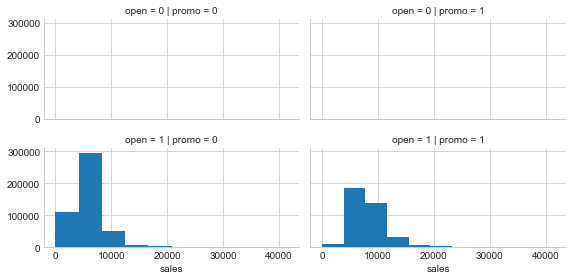

In [5]:
print(tr_merge.groupby('promo').sales.sum())
g = sns.FacetGrid(tr_merge, row='open', col='promo', size=2, aspect=2)
g = g.map(plt.hist, "sales").add_legend()

In [6]:
# Remove open != 1, because sales = 0
tr_merge = tr_merge.query('open == "1"')


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Pearson Correlation
- Observe whether there are continuous columns have linear relation with target column `sales`

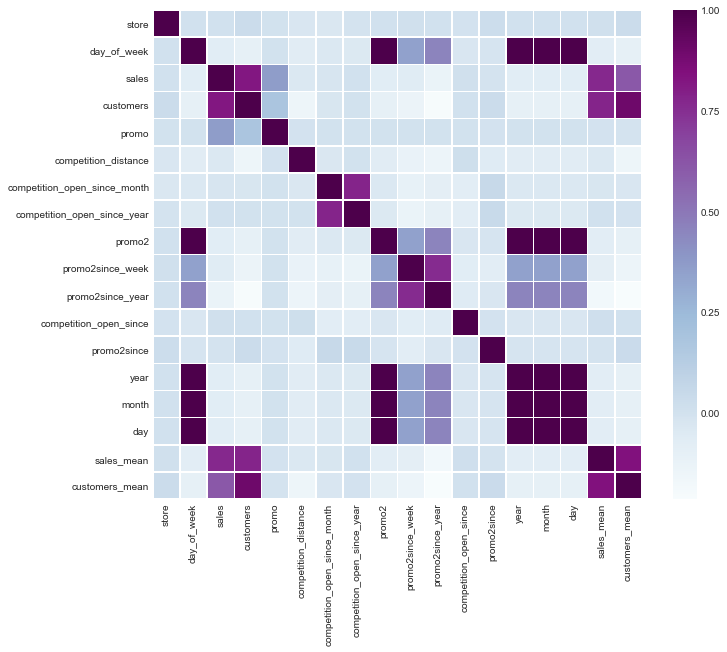

In [7]:

copy = tr_merge.copy()
copy['promo'] = copy.promo.map(int)
copy['promo2'] = copy.promo2.map(int)
copy['year'] = copy.promo2.map(int)
copy['month'] = copy.promo2.map(int)
copy['day'] = copy.promo2.map(int)
copy['day_of_week'] = copy.promo2.map(int)
corr_all = copy.corr()
del copy

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

## Observation
- **雖然Pearson Coefficient只針對連續型變數, 但是如果類別變數對應到數字後大小關係有意義, 則也可以透過Pearson Coefficient算出關聯**
- 日期相關的feature會互相有高相關, 但是這些資訊似乎沒什麼用, 而`promo2`是根據日期去算出來的, 自然也會跟日期相關feature高相關, 對預測並無太大幫助
- `customers` have siginificant positive correlation, `sales_mean`本身就是`sales`衍伸出來的欄位, 當然會Significant, 而跟`sales`高相關的`customers`衍生的`customs_mean`理所當然高相關
- `promo`和`sales`, `customer`有顯著線性正相關, 但後來發現`test.csv`並沒有customer欄位, 所以model並無法放入`customer, customer_mean` feature
- 很可惜的是, 新增的欄位 `competition_open_since`, `promo2since` 都沒有和`sales`有任何顯著的線性關係, 但我們仍然會將他放入Training
<br/>
<br/>

<br/>
<br/>
<br/>
<br/>

## 單一變數 Analysis

<br/>
<br/>
<br/>

### Promo: 看看promotion時期和平常時期的比較

promo
0    2.771974e+09
1    3.101206e+09
Name: sales, dtype: float64


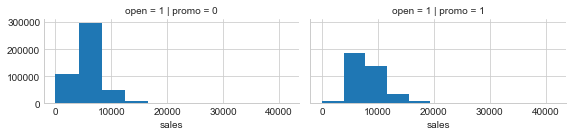

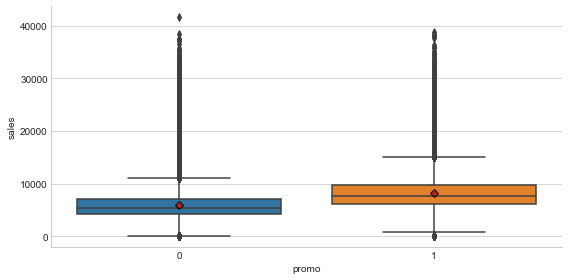

In [87]:
# plt.figure(figsize=(12, 6))
print(tr_merge.groupby('promo').sales.sum())
g = sns.FacetGrid(tr_merge, row='open', col='promo', height=2, aspect=2)
g = g.map(plt.hist, "sales").add_legend()

meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
sns.catplot(x="promo", y="sales", data=tr_merge, kind="box", height=4, aspect=2, showmeans=True, meanprops=meanprops)

In [88]:
agg = tr_merge.groupby(['promo']).sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
promo,,,,,,,,,
0,467496.0,5929.407603,2629.648385,0.0,4242.0,5459.0,7004.0,41551.0,2.771974e+09
1,376896.0,8228.281239,3175.759157,0.0,6069.0,7649.0,9686.0,38722.0,3.101206e+09


可想而知有promotion的期間大家的人均消費增高, 來客數也增多
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

### 定期性優惠(promo2)是否影響營收

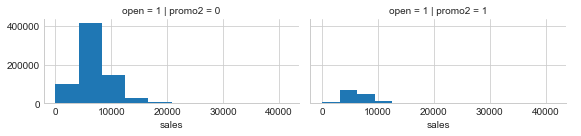

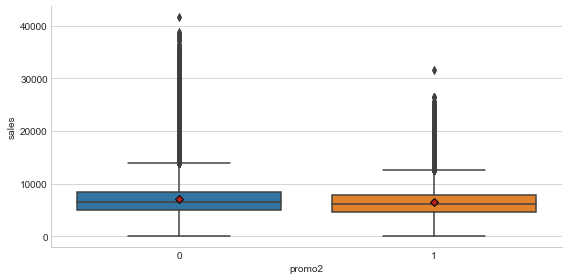

In [89]:
# plt.figure(figsize=(12, 6))
g = sns.FacetGrid(tr_merge, row='open', col='promo2', height=2, aspect=2)
g = g.map(plt.hist, "sales").add_legend()

sns.catplot(x="promo2", y="sales", data=tr_merge, kind="box", height=4, aspect=2, showmeans=True, meanprops=meanprops)

In [90]:
agg = tr_merge.groupby(['promo2']).sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
promo2,,,,,,,,,
0,699164.0,7051.816202,3185.964977,0.0,4908.0,6440.0,8476.0,41551.0,4.930376e+09
1,145228.0,6491.892748,2626.976161,0.0,4650.0,6044.0,7837.0,31523.0,9.428046e+08


- `promo2`的數量明顯較少, 因為不可能永遠都有優惠(這和第一種`promo`是一樣的狀況), 但是在優惠期間, 似乎並沒有和`promo`一樣提高營收

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

### DayOfWeek

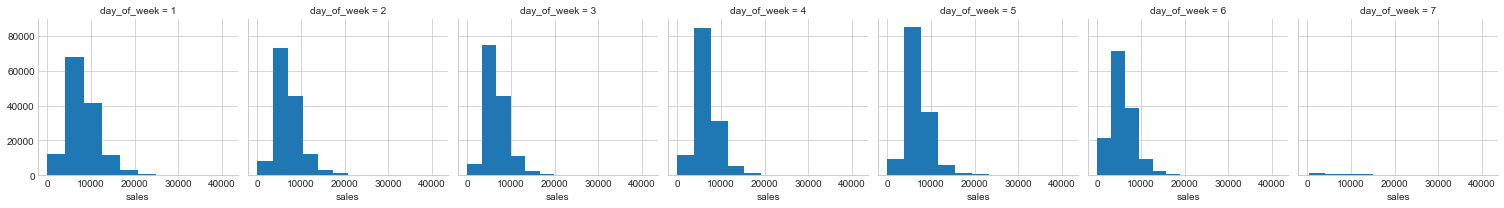

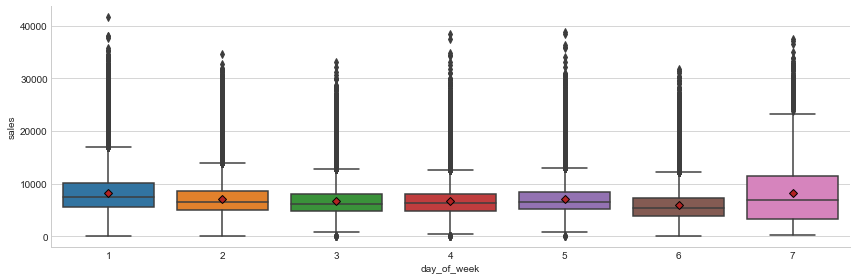

In [91]:
# plt.figure(figsize=(12, 6))
g = sns.FacetGrid(tr_merge, col='day_of_week', sharey=True, height=3, aspect=1)
g = g.map(plt.hist, "sales")

sns.catplot(x="day_of_week", y="sales", data=tr_merge, kind="box", height=4, aspect=3, showmeans=True, meanprops=meanprops)

In [93]:
agg = tr_merge.groupby('day_of_week').sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
day_of_week,,,,,,,,,
1,137560.0,8216.073074,3691.768876,0.0,5538.0,7539.0,10133.0,41551.0,1.130203e+09
2,143961.0,7088.113656,3066.237110,0.0,4960.0,6502.0,8521.0,34692.0,1.020412e+09
3,141936.0,6728.122978,2781.775174,0.0,4829.0,6210.0,7987.0,33151.0,9.549629e+08
4,134644.0,6767.310159,2764.548119,0.0,4900.0,6246.0,7987.0,38367.0,9.111777e+08
5,138640.0,7072.677012,2764.915744,0.0,5205.0,6580.0,8324.0,38722.0,9.805559e+08
6,144058.0,5874.840238,2852.730426,0.0,3925.0,5425.0,7232.0,31683.0,8.463177e+08
7,3593.0,8224.723908,6235.152960,286.0,3314.0,6876.0,11418.0,37376.0,2.955143e+07


### Obervation
- `day_of_week` = 7是假日, 但是仍然有店家開店, `count`數量一定是少數, 但是平均`sales`可以跟`day_of_week` = 1差不多高

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
## StoreType

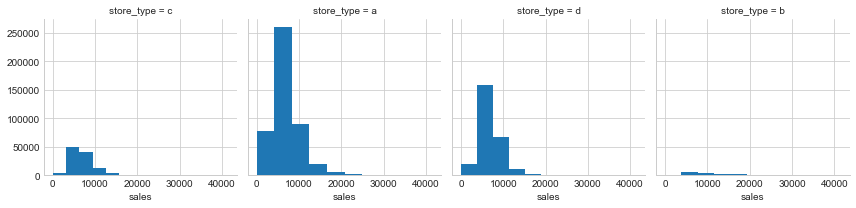

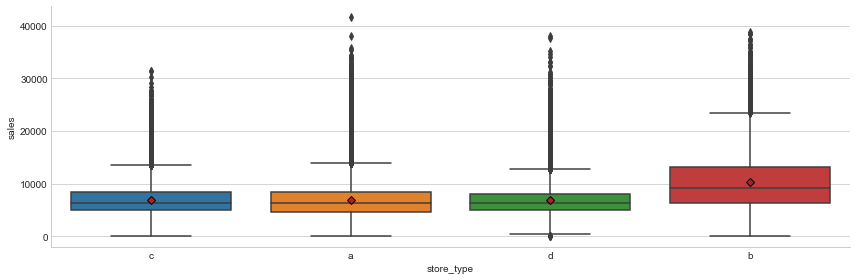

In [96]:
g = sns.FacetGrid(tr_merge, col='store_type', sharey=True, height=3, aspect=1)
g = g.map(plt.hist, "sales")

sns.catplot(x="store_type", y="sales", data=tr_merge, kind="box", height=4, aspect=3, showmeans=True, meanprops=meanprops)

In [97]:
agg = tr_merge.groupby('store_type').sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
store_type,,,,,,,,,
a,457077.0,6925.167661,3277.786381,0.0,4695.0,6285.0,8406.0,41551.0,3.165335e+09
b,15563.0,10231.407505,5157.190155,0.0,6344.0,9130.0,13183.5,38722.0,1.592314e+08
c,112978.0,6932.512755,2897.564578,0.0,4915.0,6407.0,8349.0,31448.0,7.832214e+08
d,258774.0,6822.141881,2556.582881,0.0,5050.0,6395.0,8123.0,38037.0,1.765393e+09


### Obervation
- 雖然`store_type` = b的數量少, 但是`sales`是偏高的, 代表人均消費是比較高的, 這是顯著的information
- `store_type` = a的商店來客數是最多的

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

## 雙變數分析

### Promo, SchoolHoliday 

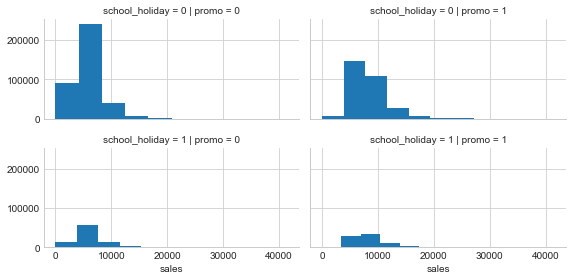

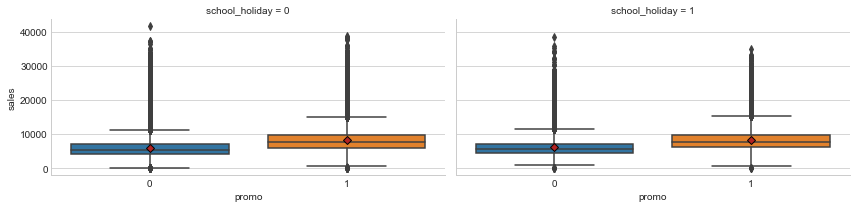

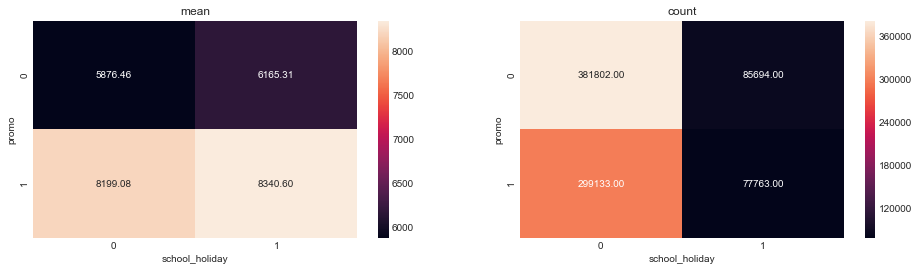

In [100]:
# print(tr_merge.groupby(['Store', 'SchoolHoliday', 'Promo']).Sales.sum())
g = sns.FacetGrid(tr_merge, row='school_holiday', col='promo', height=2, aspect=2)
g = g.map(plt.hist, "sales").add_legend()

sns.catplot(x="promo", y="sales", col='school_holiday', data=tr_merge, kind="box", height=3, aspect=2, showmeans=True, meanprops=meanprops)

utils.heatmap(tr_merge, 'promo', 'school_holiday')

### Observation
- 之前已經知道`promo`會增加`sales`, 即使假日的`count`數較少, 在`school_holiday`的日子有些許提升

<br/>
<br/>
<br/>

### Promo, StateHoliday 

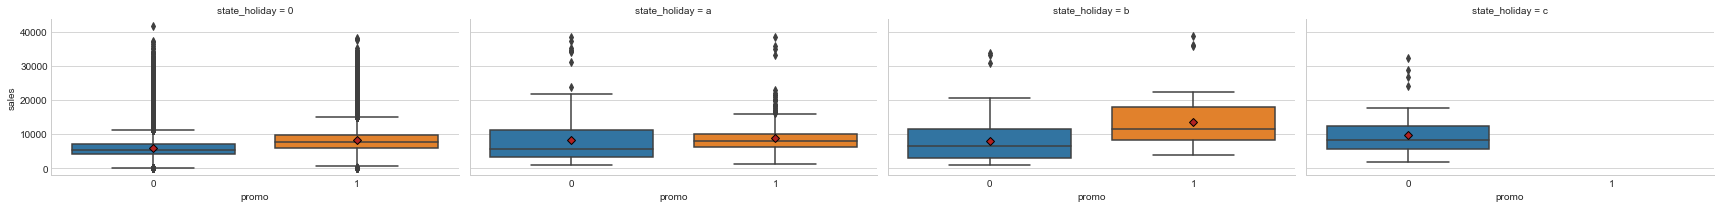

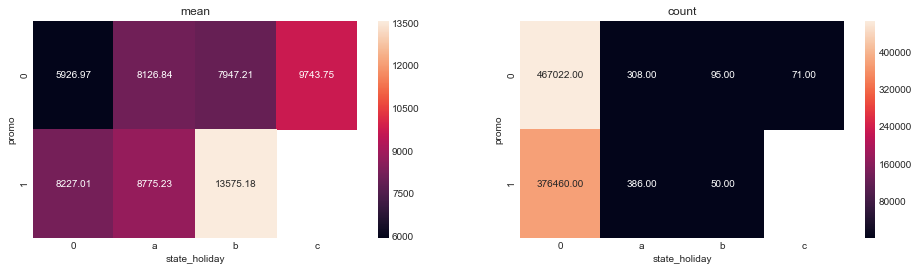

In [102]:
# g = sns.FacetGrid(tr_merge, row='StateHoliday', col='Promo', size=2, aspect=2)
# g = g.map(plt.hist, "Sales").add_legend()

sns.catplot(x="promo", y="sales", col='state_holiday', data=tr_merge, kind="box", height=3, aspect=2, showmeans=True, meanprops=meanprops)
utils.heatmap(tr_merge, 'promo', 'state_holiday')

### Observation
- `state_holiday = 0`的時候資料數量最多
- `state_holiday = b`且在promotion時期`sales`有顯著的暴增, 不是promotion時期完全沒有此狀況, 這是非常有用的information
- `state_holiday = c`且`promo = 1`的時候完全沒有資料

<br/>
<br/>
<br/>

### StateHoliday, StoreType

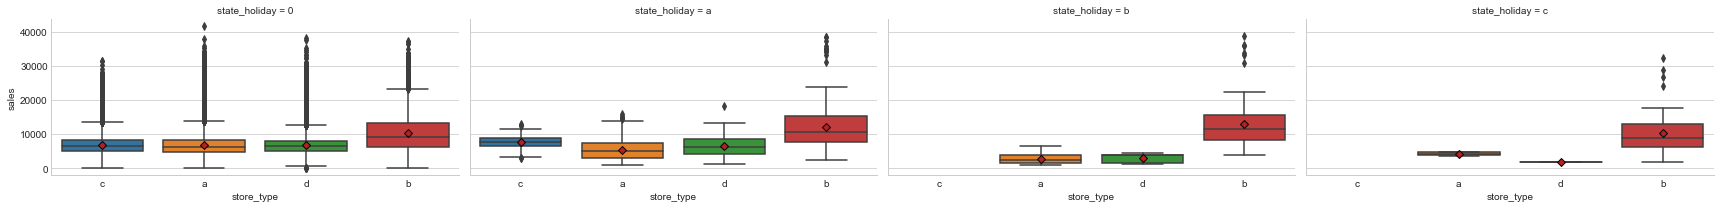

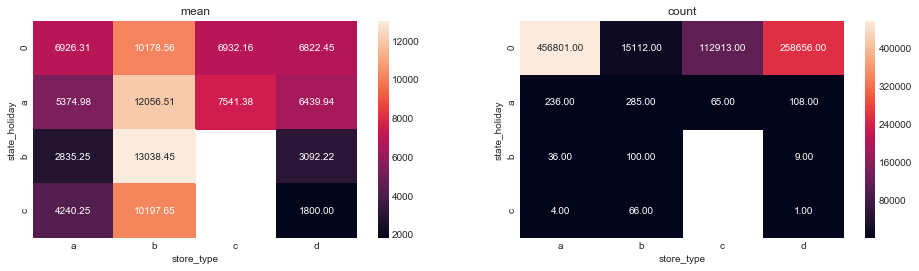

In [111]:
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
sns.catplot(x="store_type", y="sales", col='state_holiday', # row='promo', hue='assortment', 
            data=tr_merge, kind="box", height=3, aspect=2, showmeans=True, meanprops=meanprops)
utils.heatmap(tr_merge, 'state_holiday', 'store_type', annot=True)

### Observation
- `stor_type = a`的資料數量是最多的
- `state_holiday = b`, `store_type = b`都有平均`sales`暴增的狀況(並非資料數量暴增)

<br/>
<br/>
<br/>

### State, StoreType

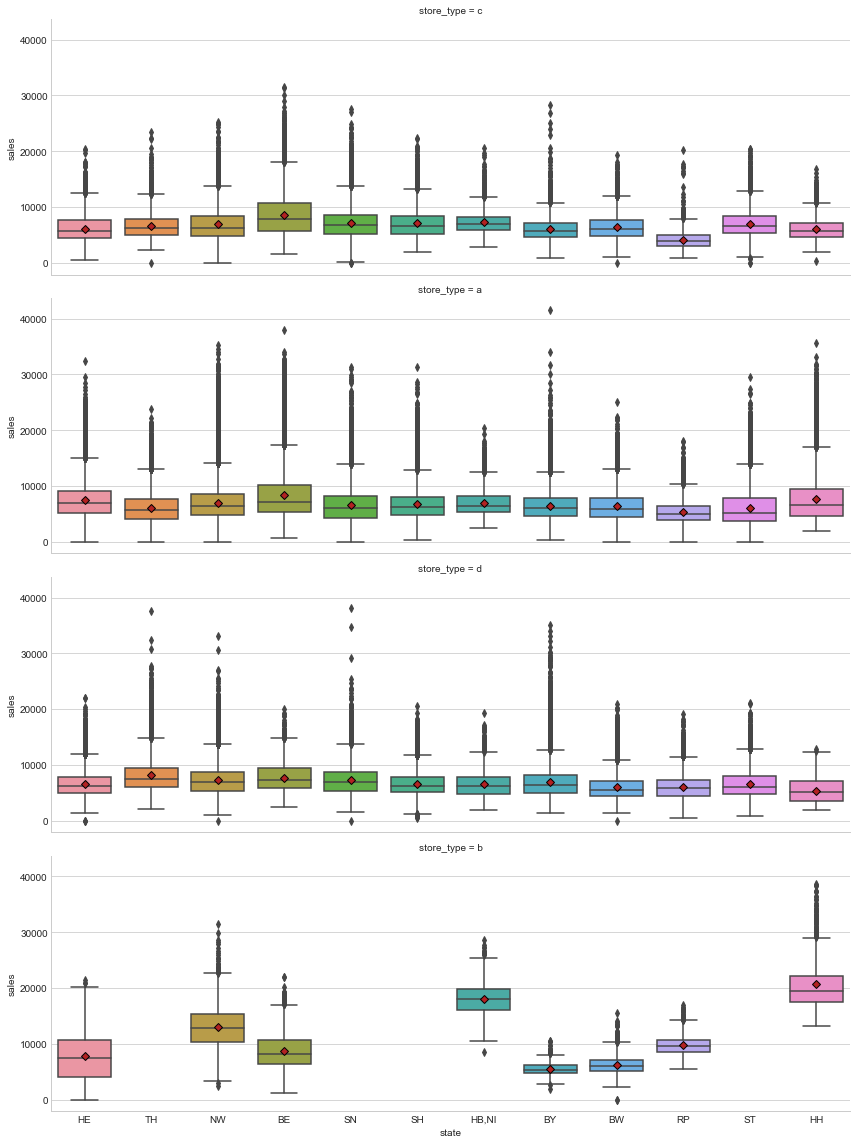

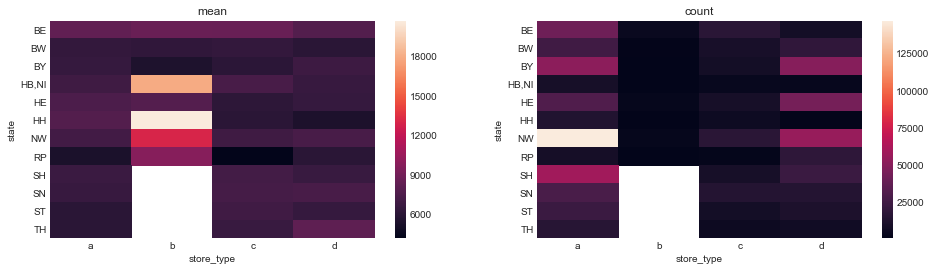

In [104]:
# g = sns.FacetGrid(tr_merge, col='State', row='StoreType', sharey=True, size=4, aspect=.5)
# g = g.map(plt.hist, "Sales")
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
sns.catplot(x="state", y="sales", row='store_type', data=tr_merge, kind="box", 
               height=4, aspect=3, showmeans=True, meanprops=meanprops)

utils.heatmap(tr_merge, 'state', 'store_type', annot=False)

### Observation
- `store_type = b`的時候許多州都沒有銷售量(沒有資料), 但是`state = 'HB,NI' 'HH' 'NW'`的時候銷售平均是很高的, 所以平均銷售最高是集中在`store_type = b`, 而且又集中在某些州

<br/>
<br/>
<br/>

### Month, Day: 會把日期放進Feature就是預期說可能某些日子, 會有不同於平時的銷售量

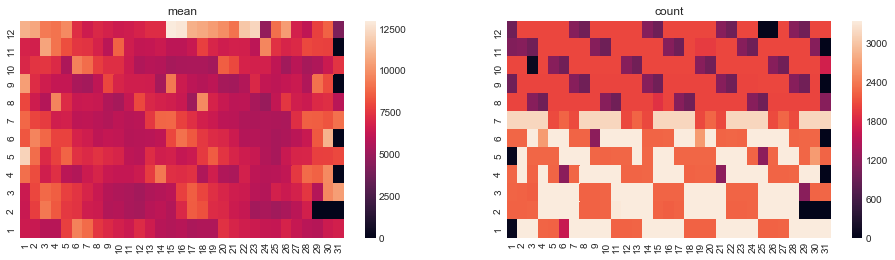

In [126]:
# sns.factorplot(x="day", y="Sales", row='month', data=tr_merge, kind="box", size=4, aspect=3)
xtick = pd.Series(tr_merge.day.unique()).map(int).sort_values().map(str)
ytick = pd.Series(tr_merge.month.unique()).map(int).sort_values(ascending=False).map(str)
utils.heatmap(tr_merge, 'month', 'day', xtick=xtick, ytick=ytick,
              annot=False)

### Observation
- 七月以後的Count人數較少, 但是Train Data裡每間商店最多只到2015-07-31, 這只是純粹最後一年少了8月初以後的資訊
- Mean的部分, 大約在`12/15 ~ 12/22`, 平均銷售量比較高

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
## 三個變數以上的觀察

### StoreType, StateHoliday, Promo, Assortment

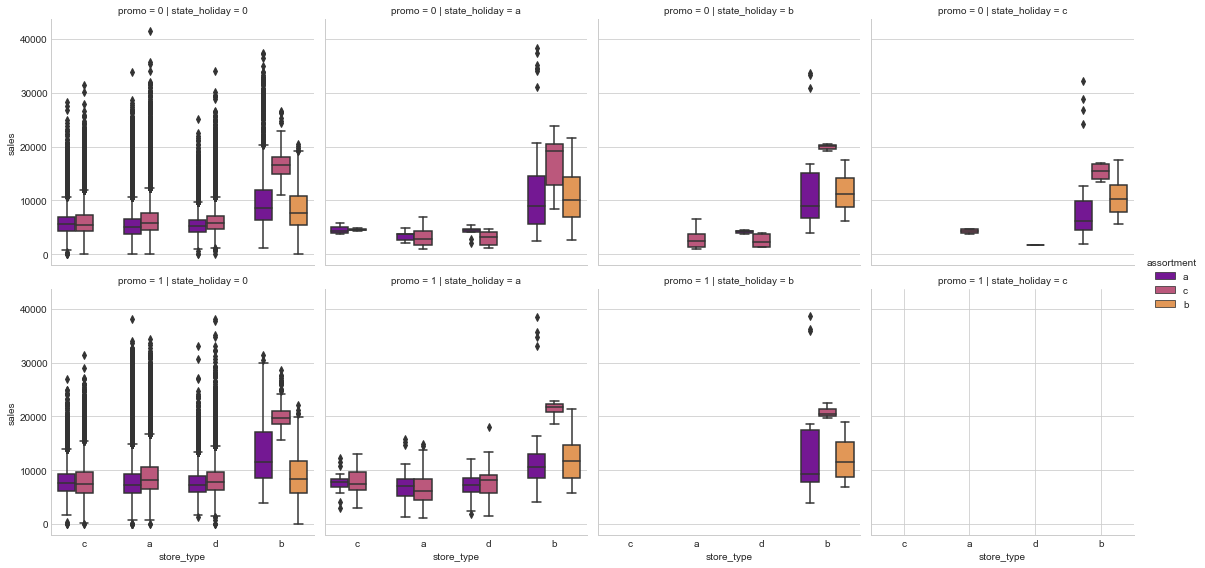

In [132]:
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
sns.catplot(data=tr_merge, x='store_type', y="sales", row='promo', col='state_holiday', hue='assortment', 
            kind='box', height=4, palette = 'plasma', meanprops=meanprops)
plt.show()

### Observation
- 從之前得知`state_holiday = b and store_type = b`的時候平均銷量最高, 而這裡加入了`assortment`之後又發現, `assortment = c`是平均銷售量貢獻最多

<br/>
<br/>
<br/>

### DayOfWeek, Promo, Promo2

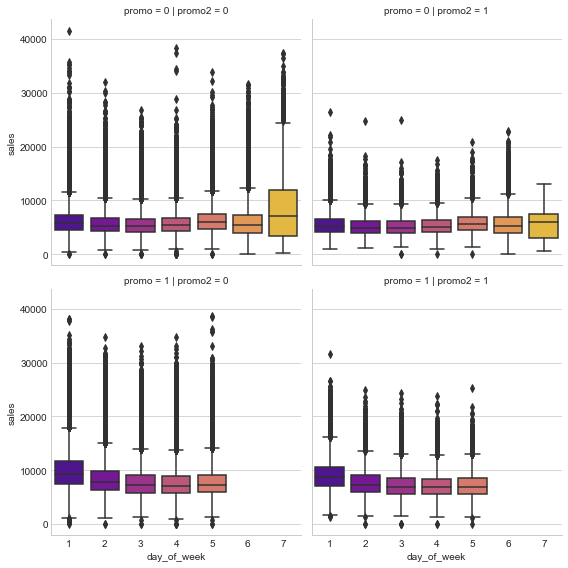

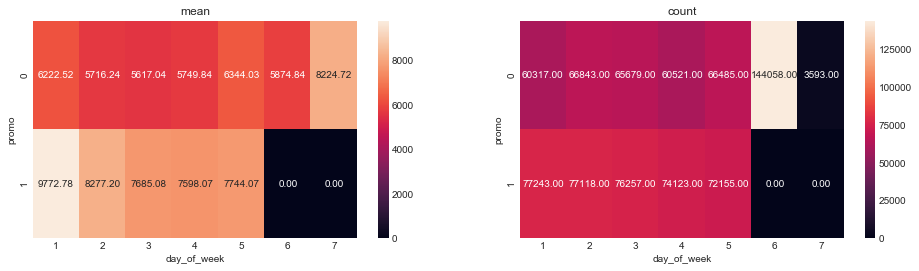

In [137]:
meanprops = dict(marker='D', markeredgecolor='red', markerfacecolor='firebrick')
sns.catplot(data=tr_merge, x='day_of_week', y="sales", row='promo', col='promo2',
            kind='box', height=4, palette = 'plasma', meanprops=meanprops)
plt.show()
utils.heatmap(tr_merge, 'promo', 'day_of_week')

### Observation
- `promo = 1 and day_of_week in (6, 7)`的時候是沒有資料的, 星期六, 日沒有promotion確實是奇怪的地方
- 星期六人數是最多的, 但平均銷售量普通, 而星期一的平均銷售量通常都很高
- `promo2`並無顯著資訊

<br/>
<br/>
<br/>

## Data Exploratory Conclusion
- `store_type = a`是人數最多的店, 但平均銷售就不是
- `store_type = b`有最高的銷售平均, 而且貢獻並不是平均分布各州, 而是集中分布在某些州
- 日期有關的feature `day_of_week, month, day`, 在某些情況會直接影響銷售量, 是顯著的feature
- `state, state_holiday`是顯著的feature

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
## Recall The Exploration
There are many combination of columns we didn't see, to view all the combination is not efficient, that's why we use embedding to encode the categorical variables, in Tensorflow, `tf.feature_columns.crossed_column` can help us to make machine learn the information hidden in data, or handle all the combination by yourself, but imagine that we couldn't expect all the crossed combination happend in training data, if some outlier happened in serving time, the performance usually bad as expected.

## Module structure
    ```
    └─trainer
        │  app_conf.py
        │  ctrl.py
        │  input.py
        │  logging.yaml
        │  metadata.py
        │  model.py
        │  service.py
        └─ utils.py        
    ```
    Directory trainer contains all modules: 
    
|File Name| Purpose
|:---|:---
|[app_conf.py](trainer/app_conf.py) | Applicaiton configures, tell where are the training data, the model checkpoint directory, and hyperparameter suggested to put app_conf.py instead of pass on the fly to controller.
|[ctrl.py](trainer/ctrl.py) |The entrance of the program, accept any parameters, protable for local terminal or restful style environment. 
|[service.py](trainer/service.py) |The business logic module behind the controller(ctrl.py) 
|[utils.py](trainer/service.py) | Utility module, some common function to put here, like logging function. 
|[metadata.py](trainer/metadata.py)|Defines: 1) task type, 2) input data header, 3) numeric and categorical feature names, 4) target feature name (and labels, for a classification task), and 5) unused feature names. 
|[input.py](trainer/input.py)| Includes: 1) data input functions to read data from csv and tfrecords files, 2) parsing functions to convert csv and tf.example to tensors, 3) function to implement your features custom  processing and creation functionality, and 4) prediction functions (for serving the model) that accepts CSV, JSON, and tf.example instances. 
|[model.py](trainer/model.py)|Includes: 1) function to create DNNRegressor, 2) function to implement for a custom estimator model_fn. 3) include **Feature class** to assign the feature spec, the feature spec usually bind for specific model, so we put them together. 

<br/>
<br/>
<br/>
## Data preprocessing
1. Data offered like this
    ```
    │  store.csv
    │  store_states.csv
    │  test.csv
    └─ train.csv
    ```
2. Data pipeline on training period we propose 4 steps: **Clean -> Prepare -> Fit -> Transform(Split)**
    - Clean: 
        - Fill missing value, drop unnecessary features
        - Rename features
        
    - Prepare: 
        - Join store and store_states to make the **Fat table**
        - Add features we mentioned in data exploration, drop also.
        - Filter some records not appropriate, like open = 0
        - Maybe persistent some files

    - Fit: 
        - Persistent the statistical information of numeric features
        - Persistent the unique count value of categorical features
        
    - Transform:
        - Normalization, logarithm ... etc.
        - Make all categorical variable to int, one hot encoding ... etc.
        - Take logarithm of the target column
        - Split: in this case we groupby store and order by date, and take 0.3 as valid data size, train data is first 0.7 part, and rest is valid data
        
    ---
    一個Data preprocess的範例
    ```python
    # Ctrl.instance.prepare(p) # (p是傳入的參數, p.path是train data的路徑)
    data = self.input.clean(p.fpath, is_serving=False)
    data = self.input.prepare(data, is_serving=False)
    data = self.input.fit(data).transform(data, is_serving=False)
    self.input.split(data)
    ```    
3. Data pipeline on serving period just 3 steps: **clean -> prepare -> transform**
    - 大致邏輯都跟training phase相同, 清理資料 -> 增加或是drop features -> 轉換features(normalize, embedding, one hot encoding...)
    
4. There is something weird is that feature `Customers` is not in the test.csv, at heatmap of pearson corr we know that this feature got linear relation with the target column, but pity is we have to drop the column.

In [9]:
%%time

p = pd.Series({'fpath': './data/train.csv'})
Ctrl.instance.prepare(p)

2018-08-13 16:02:44,697 - trainer.input - INFO [line:22] - Clean start, is_serving: False
2018-08-13 16:02:50,099 - trainer.input - INFO [line:51] - Clean take time 0:00:05.400786
2018-08-13 16:02:50,131 - trainer.input - INFO [line:55] - Prepare start, is_serving: False
2018-08-13 16:02:50,157 - trainer.input - INFO [line:93] - Persisten store to D:\Python\notebook\ml_specialized\rossmann/data/processed/prepared/store.csv
2018-08-13 16:03:07,365 - trainer.input - INFO [line:134] - Prepare take time 0:00:17.233677
2018-08-13 16:03:07,649 - trainer.input - INFO [line:146] - sales_mean.mean: 5790.497727770823, sales_mean.stdv: 2082.5033707220155, sales_mean.median: 5471.351380042463
2018-08-13 16:03:07,741 - trainer.input - INFO [line:146] - competition_open_since.mean: 14424.153547512962, competition_open_since.stdv: 1805.9849602002341, competition_open_since.median: 14641.0
2018-08-13 16:03:07,837 - trainer.input - INFO [line:146] - promo2since.mean: 15295.40708578792, promo2since.stdv

<br/>
<br/>
<br/>

## Model Structure

![model structure](./model_structure.jpg)

我們試著使用Google提供的`Wide and Deep Model`, 也使用DNN Regressor, 也就是圖中Deep Part的部分, 來做個比較, 原本主題是預測未來6個禮拜每間商店的銷售額, 對付sequence資料應該使用RNN的架構, 但是我們不喜歡它的複雜性, 我們提倡embedding的功用, 以embedding日期時間的feature來抽取資料的中的pattern或information, 選擇點對點的training而不是recurrent的training

- Deep Model
    ```python
    est = tf.estimator.DNNRegressor(
        hidden_units=[128, 64, 32],
        feature_columns=deep_columns,
        model_dir=model_dir,
        label_dimension=1,
        weight_column=None,
        optimizer=tf.train.AdamOptimizer(0.005),
        activation_fn=tf.nn.selu,
        dropout=0.3,
        input_layer_partitioner=None
    )
    ```
    - Loss function: mean squre error, default fixed by `tf.estimator.DNNRegressor` 
    - Optimizer: `tf.train.AdamOptimizer` 
    - Overfitting check: check the train section, we use best checkpoint(`trainer.model.BestScoreExporter`) picker to avoid overfitting.
    - SeLU activation function at each layer(Self Normalization)
    - DNN Structure: `input dim -> 128 -> 64 -> 32 -> 1`, embedding dimension = 3 for all category features except store
    
- Wide and Deep Model
    ```python
    est = tf.estimator.DNNLinearCombinedRegressor(
        model_dir=model_dir,
        linear_feature_columns=wide_columns,
        linear_optimizer='Ftrl',
        dnn_feature_columns=deep_columns,
        dnn_optimizer=tf.train.AdamOptimizer(learning_rate),
        dnn_hidden_units=[128, 64, 32],
        dnn_activation_fn=tf.nn.selu,
        dnn_dropout=0.3,
        label_dimension=1
    )
    ```
    - Deep的部分與Deep Model相同
    - Wide的部分我們使用預設的[FTRL Optimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer), cross column的部分我們用了幾個feature的交互作用, 如下:
    ```python
    feature_columns[f'promo_datetime_cross'] = tf.feature_column.crossed_column(
        ['promo', 'promo2', 'year', 'month', 'day', 'day_of_week'], hash_bucket_size=int(1e4))
    feature_columns[f'promo_holiday_cross'] = tf.feature_column.crossed_column(
        ['promo', 'promo2', 'state', 'state_holiday', 'school_holiday'], hash_bucket_size=int(1e4))
    feature_columns[f'store_type_cross'] = tf.feature_column.crossed_column(
        ['state', 'store_type', 'assortment', 'day_of_week'], hash_bucket_size=int(1e4))
    feature_columns[f'competition_cross'] = tf.feature_column.crossed_column(
        ['competition_open_since_month', 'competition_open_since_year'], hash_bucket_size=int(1e4))
    ```
    - When validation time, we observe the `RMSPE(Root Mean Square Percentage Error)` error metrics
    $$ \sqrt{\frac{1}{n} \sum^{n}_{i=1} {\frac{y_i - \hat{y_i}}{y_i}}^2} $$
<br/>
<br/>


## Training

我們使用`tf.estimator.train_and_evaluate` function, 他要求三個參數, `estimator, train_spec, eval_spec`
- estimator: `tf.estimator.DNNRegressor` or `tf.estimator.DNNLinearCombinedRegressor`
- train_spec and eval_spec: 
  train_spec和eval_spec都要求data function, 這個function可以一直批次的吐出data, 內部有個隱性的迴圈, 這裡我們使用[tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) api去擷取資料, 他底層可支援多核心同時運算加快資料IO速度, , 範例如下:
    ```python
        def generate_input_fn(self,
              file_names_pattern, mode, skip_header_lines=False, is_serving=False,
              batch_size=256, num_epochs=1, num_threads=4):
    
            buffer_size = batch_size * 2
            def _input_fn():
                num_threads = multiprocessing.cpu_count() if multi_threading else 1
                file_names = tf.matching_files(file_names_pattern)

                is_serving = True if mode == tf.estimator.ModeKeys.PREDICT else False
                dataset = tf.data.TextLineDataset(filenames=file_names)
                dataset = dataset.skip(skip_header_lines)
                dataset = dataset.map(lambda csv_row: self.parse_csv(csv_row, is_serving=is_serving))
                dataset = dataset.map(lambda features: self.get_features_target_tuple(features), 
                                      num_parallel_calls=num_threads)
                if shuffle:
                    dataset = dataset.shuffle(buffer_size)
                dataset = dataset.batch(batch_size)\
                                 .prefetch(buffer_size)\
                                 .repeat(num_epochs)
                iterator = dataset.make_one_shot_iterator()
                features, target = iterator.get_next()
                return features, target
        return _input_fn
    ```
  其中參數`num_threads`就是指定多少cpu core去平行處理您的資料
  
  <br/>
  
  Train, eval spec的範例如下
    ```python
    # Train spec
    train_fn = generate_input_fn(...)
    train_spec = tf.estimator.TrainSpec(
        train_fn,
        max_steps=train_steps,
    )
    # Valid spec
    valid_fn = generate_input_fn(...)
    eval_spec = tf.estimator.EvalSpec(
        valid_fn,
        steps=valid_steps,
        exporters=[exporter]
    )
    ```
  EvalSpec的參數`exporters`是evaluate的時候選擇如何去export您的model, 這裡並不是model checkpoint files, 而是[protobufs](https://www.tensorflow.org/extend/tool_developers/#protocol_buffers)檔(`.pb`), 我們可以自訂exporter, 透過繼承`tf.estimator.Exporter`撰寫自己export的邏輯, 這裡我們實作`BestScoreExporter`, 在eval時期我們比對過去eval的metric, 像是loss, 或是accuracy, 如果這次的eval結果有更好(像是loss更低或是accuracy更高), 就export model, 否則不export
    ```python
    class BestScoreExporter(tf.estimator.Exporter):
        # ...
        def export(self, estimator, export_path, checkpoint_path, eval_result,
             is_the_final_export):

            print(f'eval_result: {eval_result}')
            curloss = eval_result['rmspe']
            if self.best is None or self.best >= curloss:
                estimator.export_savedmodel(
                    export_path,
                    self.serving_input_receiver_fn,
                    assets_extra=self.assets_extra,
                    as_text=self.as_text,
                    checkpoint_path=checkpoint_path)
            else:
                # do nothing
    ```
    
- 其他設定:
    - Batch size = 256
    - Train steps = 2308 * 8 (about 8 epochs)
    - Valid steps = 989 (about 1 epoch)
    - Drop out rate: 0.3

## Model比較

我們用了4種情況下去做比較
- DNN with hidden layer [128, 64, 32, 1]
- DNN with hidden layer [1024, 512, 256, 1]
- Wide and Deep with hidden layer [128, 64, 32, 1]
- Ridge regression
    - Ridge regression的objective function已經包含了l2 regularization的項目, 限制weights會壓縮到0附近! 較能夠防止overfitting
    $$ \min_w {\left|\left| X_w - y \right|\right|_2}^2 + \alpha{\left|\left| w \right|\right|_2}^2 $$
    - alpha是regularization的強度, 這裡我們試過要調整大一些在valid data上的表現會比較好(大於0.1)

### Deep model
- 在`trainer.app_conf.Config.mlp_layers`可更改layer設定

In [ ]:
%%time
params = pd.Series({
    'reset': True,
    'model_name': 'deep'
})
Ctrl.instance.train(params)

### Wide and deep model

In [8]:
%%time

params = pd.Series({
    'reset': True,
    'model_name': 'wide_and_deep'
})
Ctrl.instance.train(params)

2018-08-13 17:26:01,472 - trainer.service - INFO [line:91] - Model_name: wide_and_deep
2018-08-13 17:26:01,473 - trainer.service - INFO [line:92] - Model directory: D:\Python\notebook\ml_specialized\rossmann/models/wide_and_deep
2018-08-13 17:26:01,474 - BestScoreExporter - INFO [line:170] - BestScoreExporter init, last best eval is None
2018-08-13 17:26:01,479 - trainer.input - INFO [line:273] - Feature stats were successfully loaded from local file...
INFO:tensorflow:Using config: {'_model_dir': 'D:\\Python\\notebook\\ml_specialized\\rossmann/models/wide_and_deep', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
graph_options {
  optimizer_options {
    global_jit_level: ON_1
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 500, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': 

2018-08-13 17:27:26,491 - tensorflow - INFO [line:115] - Saving checkpoints for 2311 into D:\Python\notebook\ml_specialized\rossmann/models/wide_and_deep\model.ckpt.
INFO:tensorflow:Loss for final step: 65.159775.
2018-08-13 17:27:27,007 - tensorflow - INFO [line:115] - Loss for final step: 65.159775.
2018-08-13 17:27:27,022 - trainer.input - INFO [line:456] - 
2018-08-13 17:27:27,023 - trainer.input - INFO [line:457] - * data input_fn:
2018-08-13 17:27:27,024 - trainer.input - INFO [line:458] - ================
2018-08-13 17:27:27,026 - trainer.input - INFO [line:459] - Mode: eval
2018-08-13 17:27:27,027 - trainer.input - INFO [line:460] - Input file(s): D:\Python\notebook\ml_specialized\rossmann/data/processed/transformed/vl.csv
2018-08-13 17:27:27,028 - trainer.input - INFO [line:461] - Files encoding: csv
2018-08-13 17:27:27,028 - trainer.input - INFO [line:462] - Batch size: 256
2018-08-13 17:27:27,030 - trainer.input - INFO [line:463] - Epoch count: 1
2018-08-13 17:27:27,032 - tr

2018-08-13 17:28:06,634 - tensorflow - INFO [line:115] - 'serving_default' : Regression input must be a single string Tensor; got {'sales_mean': <tf.Tensor 'sales_mean:0' shape=(?,) dtype=float32>, 'competition_open_since': <tf.Tensor 'competition_open_since:0' shape=(?,) dtype=float32>, 'promo2since': <tf.Tensor 'promo2since:0' shape=(?,) dtype=float32>, 'competition_distance': <tf.Tensor 'competition_distance:0' shape=(?,) dtype=float32>, 'state': <tf.Tensor 'state:0' shape=(?,) dtype=string>, 'state_holiday': <tf.Tensor 'state_holiday:0' shape=(?,) dtype=string>, 'assortment': <tf.Tensor 'assortment:0' shape=(?,) dtype=string>, 'store_type': <tf.Tensor 'store_type:0' shape=(?,) dtype=string>, 'competition_open_since_month': <tf.Tensor 'competition_open_since_month:0' shape=(?,) dtype=string>, 'competition_open_since_year': <tf.Tensor 'competition_open_since_year:0' shape=(?,) dtype=string>, 'promo2since_week': <tf.Tensor 'promo2since_week:0' shape=(?,) dtype=string>, 'promo2since_ye

INFO:tensorflow:loss = 79.598465, step = 2311
2018-08-13 17:28:15,084 - tensorflow - INFO [line:115] - loss = 79.598465, step = 2311
INFO:tensorflow:global_step/sec: 29.0269
2018-08-13 17:28:32,311 - tensorflow - INFO [line:115] - global_step/sec: 29.0269
INFO:tensorflow:loss = 71.051285, step = 2811 (17.232 sec)
2018-08-13 17:28:32,318 - tensorflow - INFO [line:115] - loss = 71.051285, step = 2811 (17.232 sec)
INFO:tensorflow:global_step/sec: 31.3212
2018-08-13 17:28:48,273 - tensorflow - INFO [line:115] - global_step/sec: 31.3212
INFO:tensorflow:loss = 48.500805, step = 3311 (15.957 sec)
2018-08-13 17:28:48,273 - tensorflow - INFO [line:115] - loss = 48.500805, step = 3311 (15.957 sec)
INFO:tensorflow:global_step/sec: 30.5593
2018-08-13 17:29:04,635 - tensorflow - INFO [line:115] - global_step/sec: 30.5593
INFO:tensorflow:loss = 38.963306, step = 3811 (16.371 sec)
2018-08-13 17:29:04,644 - tensorflow - INFO [line:115] - loss = 38.963306, step = 3811 (16.371 sec)
INFO:tensorflow:globa

2018-08-13 17:30:10,795 - tensorflow - INFO [line:115] - Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:
INFO:tensorflow:'serving_default' : Regression input must be a single string Tensor; got {'sales_mean': <tf.Tensor 'sales_mean:0' shape=(?,) dtype=float32>, 'competition_open_since': <tf.Tensor 'competition_open_since:0' shape=(?,) dtype=float32>, 'promo2since': <tf.Tensor 'promo2since:0' shape=(?,) dtype=float32>, 'competition_distance': <tf.Tensor 'competition_distance:0' shape=(?,) dtype=float32>, 'state': <tf.Tensor 'state:0' shape=(?,) dtype=string>, 'state_holiday': <tf.Tensor 'state_holiday:0' shape=(?,) dtype=string>, 'assortment': <tf.Tensor 'assortment:0' shape=(?,) dtype=string>, 'store_type': <tf.Tensor 'store_type:0' shape=(?,) dtype=string>, 'competition_open_since_month': <tf.Tensor 'competition_open_since_month:0' shape=(?,) dtype=string>, 'competition_open_since_year': <tf.Tensor 'competition_open_since_year:0' shape=(?,

2018-08-13 17:30:11,249 - trainer.input - INFO [line:466] - ================
2018-08-13 17:30:11,249 - trainer.input - INFO [line:467] - 
2018-08-13 17:30:11,258 - trainer.input - INFO [line:407] - is_serving: False
INFO:tensorflow:Calling model_fn.
2018-08-13 17:30:11,324 - tensorflow - INFO [line:115] - Calling model_fn.
INFO:tensorflow:Calling model_fn.
2018-08-13 17:30:11,324 - tensorflow - INFO [line:115] - Calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-08-13 17:30:13,505 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-08-13 17:30:13,505 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
2018-08-13 17:30:13,514 - tensorflow - INFO [line:115] - Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
2018-08-13 17:30:13,744 - tensorflow - INFO [line:115] - Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\rossmann

2018-08-13 17:32:16,421 - trainer.input - INFO [line:458] - ================
2018-08-13 17:32:16,422 - trainer.input - INFO [line:459] - Mode: train
2018-08-13 17:32:16,422 - trainer.input - INFO [line:460] - Input file(s): D:\Python\notebook\ml_specialized\rossmann/data/processed/transformed/tr.csv
2018-08-13 17:32:16,423 - trainer.input - INFO [line:461] - Files encoding: csv
2018-08-13 17:32:16,423 - trainer.input - INFO [line:462] - Batch size: 256
2018-08-13 17:32:16,424 - trainer.input - INFO [line:463] - Epoch count: 1
2018-08-13 17:32:16,425 - trainer.input - INFO [line:464] - Thread count: 8
2018-08-13 17:32:16,425 - trainer.input - INFO [line:465] - Shuffle: True
2018-08-13 17:32:16,426 - trainer.input - INFO [line:466] - ================
2018-08-13 17:32:16,426 - trainer.input - INFO [line:467] - 
2018-08-13 17:32:16,433 - trainer.input - INFO [line:407] - is_serving: False
INFO:tensorflow:Calling model_fn.
2018-08-13 17:32:16,514 - tensorflow - INFO [line:115] - Calling mod

2018-08-13 17:34:23,993 - tensorflow - INFO [line:115] - Saving 'checkpoint_path' summary for global step 9244: D:\Python\notebook\ml_specialized\rossmann/models/wide_and_deep\model.ckpt-9244
2018-08-13 17:34:23,994 - BestScoreExporter - INFO [line:191] - eval_result: {'average_loss': 0.04397136, 'loss': 11.251862, 'mae': 0.1573377, 'rmse': 0.20969349, 'rmspe': 0.29269335, 'global_step': 9244}
2018-08-13 17:34:23,994 - BestScoreExporter - INFO [line:214] - bad eval loss: 0.2926933467388153
2018-08-13 17:34:24,034 - trainer.input - INFO [line:456] - 
2018-08-13 17:34:24,034 - trainer.input - INFO [line:457] - * data input_fn:
2018-08-13 17:34:24,034 - trainer.input - INFO [line:458] - ================
2018-08-13 17:34:24,034 - trainer.input - INFO [line:459] - Mode: train
2018-08-13 17:34:24,034 - trainer.input - INFO [line:460] - Input file(s): D:\Python\notebook\ml_specialized\rossmann/data/processed/transformed/tr.csv
2018-08-13 17:34:24,034 - trainer.input - INFO [line:461] - Files 

2018-08-13 17:36:25,704 - tensorflow - INFO [line:115] - Finished evaluation at 2018-08-13-09:36:25
INFO:tensorflow:Saving dict for global step 11555: average_loss = 0.050415926, global_step = 11555, loss = 12.900966, mae = 0.17446429, rmse = 0.22453491, rmspe = 0.2746437
2018-08-13 17:36:25,704 - tensorflow - INFO [line:115] - Saving dict for global step 11555: average_loss = 0.050415926, global_step = 11555, loss = 12.900966, mae = 0.17446429, rmse = 0.22453491, rmspe = 0.2746437
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11555: D:\Python\notebook\ml_specialized\rossmann/models/wide_and_deep\model.ckpt-11555
2018-08-13 17:36:25,714 - tensorflow - INFO [line:115] - Saving 'checkpoint_path' summary for global step 11555: D:\Python\notebook\ml_specialized\rossmann/models/wide_and_deep\model.ckpt-11555
2018-08-13 17:36:25,714 - BestScoreExporter - INFO [line:191] - eval_result: {'average_loss': 0.050415926, 'loss': 12.900966, 'mae': 0.17446429, 'rmse': 0.22453491, '

2018-08-13 17:36:26,975 - tensorflow - WARNING [line:120] - Export includes no default signature!
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/wide_and_deep\model.ckpt-11555
2018-08-13 17:36:27,032 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/wide_and_deep\model.ckpt-11555
INFO:tensorflow:Assets added to graph.
2018-08-13 17:36:27,084 - tensorflow - INFO [line:115] - Assets added to graph.
INFO:tensorflow:No assets to write.
2018-08-13 17:36:27,084 - tensorflow - INFO [line:115] - No assets to write.
INFO:tensorflow:SavedModel written to: D:\Python\notebook\ml_specialized\rossmann/models/wide_and_deep\export\estimator\temp-b'1534152985'\saved_model.pb
2018-08-13 17:36:27,394 - tensorflow - INFO [line:115] - SavedModel written to: D:\Python\notebook\ml_specialized\rossmann/models/wide_and_deep\export\estimator\temp-b'1534152985'\saved_model.pb
2018-08-13 17:36:27,429 - trainer.

2018-08-13 17:38:18,110 - tensorflow - INFO [line:115] - Evaluation [588/989]
INFO:tensorflow:Evaluation [686/989]
2018-08-13 17:38:21,493 - tensorflow - INFO [line:115] - Evaluation [686/989]
INFO:tensorflow:Evaluation [784/989]
2018-08-13 17:38:25,144 - tensorflow - INFO [line:115] - Evaluation [784/989]
INFO:tensorflow:Evaluation [882/989]
2018-08-13 17:38:28,494 - tensorflow - INFO [line:115] - Evaluation [882/989]
INFO:tensorflow:Evaluation [980/989]
2018-08-13 17:38:31,854 - tensorflow - INFO [line:115] - Evaluation [980/989]
INFO:tensorflow:Finished evaluation at 2018-08-13-09:38:32
2018-08-13 17:38:32,134 - tensorflow - INFO [line:115] - Finished evaluation at 2018-08-13-09:38:32
INFO:tensorflow:Saving dict for global step 13866: average_loss = 0.04955131, global_step = 13866, loss = 12.679718, mae = 0.17080946, rmse = 0.22260123, rmspe = 0.2495311
2018-08-13 17:38:32,134 - tensorflow - INFO [line:115] - Saving dict for global step 13866: average_loss = 0.04955131, global_step 

2018-08-13 17:38:33,581 - tensorflow - INFO [line:115] - 'regression' : Regression input must be a single string Tensor; got {'sales_mean': <tf.Tensor 'sales_mean:0' shape=(?,) dtype=float32>, 'competition_open_since': <tf.Tensor 'competition_open_since:0' shape=(?,) dtype=float32>, 'promo2since': <tf.Tensor 'promo2since:0' shape=(?,) dtype=float32>, 'competition_distance': <tf.Tensor 'competition_distance:0' shape=(?,) dtype=float32>, 'state': <tf.Tensor 'state:0' shape=(?,) dtype=string>, 'state_holiday': <tf.Tensor 'state_holiday:0' shape=(?,) dtype=string>, 'assortment': <tf.Tensor 'assortment:0' shape=(?,) dtype=string>, 'store_type': <tf.Tensor 'store_type:0' shape=(?,) dtype=string>, 'competition_open_since_month': <tf.Tensor 'competition_open_since_month:0' shape=(?,) dtype=string>, 'competition_open_since_year': <tf.Tensor 'competition_open_since_year:0' shape=(?,) dtype=string>, 'promo2since_week': <tf.Tensor 'promo2since_week:0' shape=(?,) dtype=string>, 'promo2since_year': 

INFO:tensorflow:Done calling model_fn.
2018-08-13 17:40:01,508 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-13-09:40:01
2018-08-13 17:40:01,528 - tensorflow - INFO [line:115] - Starting evaluation at 2018-08-13-09:40:01
INFO:tensorflow:Graph was finalized.
2018-08-13 17:40:01,644 - tensorflow - INFO [line:115] - Graph was finalized.
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/wide_and_deep\model.ckpt-16177
2018-08-13 17:40:01,654 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/wide_and_deep\model.ckpt-16177
INFO:tensorflow:Running local_init_op.
2018-08-13 17:40:01,744 - tensorflow - INFO [line:115] - Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2018-08-13 17:40:01,804 - tensorflow - INFO [line:115] - Done running local_init_op.
INFO:tensorflow:Evaluation [98/989]
2018-08-13 17:40:06,192 - tensorflow

2018-08-13 17:42:03,216 - trainer.input - INFO [line:464] - Thread count: 8
2018-08-13 17:42:03,217 - trainer.input - INFO [line:465] - Shuffle: False
2018-08-13 17:42:03,218 - trainer.input - INFO [line:466] - ================
2018-08-13 17:42:03,218 - trainer.input - INFO [line:467] - 
2018-08-13 17:42:03,224 - trainer.input - INFO [line:407] - is_serving: False
INFO:tensorflow:Calling model_fn.
2018-08-13 17:42:03,321 - tensorflow - INFO [line:115] - Calling model_fn.
INFO:tensorflow:Calling model_fn.
2018-08-13 17:42:03,323 - tensorflow - INFO [line:115] - Calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-08-13 17:42:04,531 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
2018-08-13 17:42:04,587 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-13-09:42:04
2018-08-13 17:42:04,609 - tensorflow - INFO [line:115] - Starting evaluation at 2018-08-13-09:42:04
INFO:tensorflow:Gr

### Ridge Regression

In [3]:
%%time

params = pd.Series({
    'reset': False,
    'model_name': 'ridge'
})
Ctrl.instance.train(params)

2018-08-13 16:38:11,911 - trainer.service - INFO [line:58] - RMSPE on train data: 0.25172015125764613, valid data: 0.3254622870762049
2018-08-13 16:38:11,925 - trainer.service - INFO [line:59] - RMSE on train data: 0.1929401075111576, valid data: 0.20696600800731926
Wall time: 1min 10s


## Model Comparison Observation

1. DNNRegressor training 時觀察`RMSE`, `RMSPE`的變化, 由於我們對target欄位`sales`取log, training時`RMSE`是取log之後的比較, 上述的function rmse就沒有使用
`np.expm1`, `RMSPE`則有, kaggle的審核標準是`RMSPE`.

<br/>
<br/>

### 由上述可得到下列table
------------
   | DNNRegressor | DNNRegressor(large layer dimension) | DNNLinearCombinedRegressor(Wide and Deep) | Scikit-learn Ridge Regression 
---|---
RMSPE | 0.2537  | 0.2669 | **0.2495** | 0.3255
RMSE  | **0.1983** | 0.2067 | 0.2015 | 0.2069

<br/>
<br/>

看表得知似乎冠軍是Wide and Deep Model(以RMSPE為主), 但以這個case我們會以DNNRegressor為主, 原因沒有其他, 就是參數少而且效果並沒有更差, 事實上小數點第一位之後的誤差應該可以忽略, 

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Protocol buffer file inspection
- Use saved_model_cli to inspect the protocol buff schema

In [5]:
export_dir = utils.find_latest_expdir(app_conf.instance)
print( utils.cmd(f'saved_model_cli show --dir {export_dir}') )

The given SavedModel contains the following tag-sets:
serve



In [6]:
export_dir = utils.find_latest_expdir(app_conf.instance)
print( utils.cmd(f'saved_model_cli show --dir {export_dir} --tag_set serve') )

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "predict"



In [4]:
export_dir = utils.find_latest_expdir(app_conf.instance)
command = f'saved_model_cli show --dir {export_dir} --tag_set serve --signature_def predict'
print( utils.cmd(command) )

The given SavedModel SignatureDef contains the following input(s):
  inputs['assortment'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: assortment:0
  inputs['competition_distance'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: competition_distance:0
  inputs['competition_open_since'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: competition_open_since:0
  inputs['competition_open_since_month'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: competition_open_since_month:0
  inputs['competition_open_since_year'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: competition_open_since_year:0
  inputs['day'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: day:0
  inputs['day_of_week'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: day_of_week:0
  inputs['month'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: month:0
  inputs['open'] tensor_inf

## Local prediction
1. Transform raw input data for prediction
2. Local prediction
    - call ctrl.local_predict: simply use `tensorflow.contrib.predictor`
        ```python
        from tensorflow.contrib import predictor
        predict_fn = predictor.from_saved_model(export_dir, signature_def_key='predict')
        pred = predict_fn( ... )
        ```
3. Online prediciton
    - deploy model to ml-engine
        1. Create model reository(resource)
        2. Add version in model container, in this example we clean the reository first (delete all old version)
        3. Determine the **default version**, default is the latest version
    - call ctrl.online_predict
    
4. In this case, we need to take np.expm1 to the predict result

In [7]:
test_df = Ctrl.instance.transform(pd.Series({'fpath': './data/test.csv'}))
params = pd.Series({
    'datasource': test_df,
    'is_src_file': False
})
pred = Ctrl.instance.local_predict(params)
print(pred)

2018-08-02 11:32:51,783 - trainer.input - INFO [line:22] - Clean start, is_serving: True
2018-08-02 11:32:51,955 - trainer.input - INFO [line:51] - Clean take time 0:00:00.170678
2018-08-02 11:32:51,957 - trainer.input - INFO [line:55] - Prepare start, is_serving: True
2018-08-02 11:32:52,357 - trainer.input - INFO [line:134] - Prepare take time 0:00:00.397967
2018-08-02 11:32:52,361 - trainer.input - INFO [line:166] - Prepare start, is_serving: True
2018-08-02 11:32:54,068 - trainer.input - INFO [line:183] - Transform take time 0:00:01.706096
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_ooo/export/estimator/1533180707\variables\variables
2018-08-02 11:32:55,176 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_ooo/export/estimator/1533180707\variables\variables
[  72. 1918. 1070. ...  226.   12.   83.]
Wall time: 4.11 s


<br/>
<br/>
<br/>

## Deply to ml-engine

- Set environ variable to read the api key json file: 
    - In trainer/app_conf.py, `Config.api_key_path` set the API key json path to acquire the access to any GCP service

In [18]:
%%time
Ctrl.instance.set_client_secret()

2018-08-13 18:02:02,039 - trainer.ctrl - INFO [line:22] - Set env variable [GOOGLE_APPLICATION_CREDENTIALS]
Wall time: 2 ms


- Upload saved pb file to GCS

In [16]:
%%time

p = pd.Series({
    # `bucket_name` and `prefix` tell Where to place the model on cloud ==> gs://{bucket_name}/{prefix}
    'bucket_name': 'ml-specialized',
    'prefix': 'rossmann/models',
    'model_path': service.Service.instance.find_latest_expdir('deep'),
})
Ctrl.instance.upload_model(p)

2018-08-13 18:00:09,741 - trainer.ctrl - INFO [line:72] - copy D:\Python\notebook\ml_specialized\rossmann\models\dnn_regressor_128_64_32\export\estimator\1534150635/saved_model.pb to rossmann/models/saved_model.pb
2018-08-13 18:00:10,642 - trainer.ctrl - INFO [line:72] - copy D:\Python\notebook\ml_specialized\rossmann\models\dnn_regressor_128_64_32\export\estimator\1534150635\variables/variables.data-00000-of-00001 to rossmann/models/variables/variables.data-00000-of-00001
2018-08-13 18:00:11,249 - trainer.ctrl - INFO [line:72] - copy D:\Python\notebook\ml_specialized\rossmann\models\dnn_regressor_128_64_32\export\estimator\1534150635\variables/variables.index to rossmann/models/variables/variables.index
Wall time: 2.35 s


### Deploy
- Create model resource and version
- Call deploy api

In [19]:
%%time

p = pd.Series({
    'model_name': 'ml_specilized_rossmann',
    'deployment_uri': 'gs://ml-specialized/rossmann/models'
})
Ctrl.instance.deploy(p)

2018-08-13 18:03:17,006 - googleapiclient.discovery - INFO [line:274] - URL being requested: GET https://www.googleapis.com/discovery/v1/apis/ml/v1/rest
2018-08-13 18:03:22,696 - googleapiclient.discovery - INFO [line:868] - URL being requested: POST https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models?alt=json
2018-08-13 18:03:22,698 - oauth2client.transport - INFO [line:151] - Attempting refresh to obtain initial access_token
2018-08-13 18:03:22,700 - oauth2client.client - INFO [line:795] - Refreshing access_token
2018-08-13 18:03:24,253 - trainer.service - WARNING [line:180] - <HttpError 409 when requesting https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models?alt=json returned "Field: model.name Error: A model with the same name already exists.">
2018-08-13 18:03:24,261 - googleapiclient.discovery - INFO [line:868] - URL being requested: GET https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models/ml_specilized_rossmann/versions?alt=json
2018-08-13 18:03:24

### Call deployed model
Because of the traffic volume limitation, just show first 100 rows online prediction

In [21]:
test_df = Ctrl.instance.transform(pd.Series({'fpath': './data/test.csv'}))
p = pd.Series({
    'model_name': 'ml_specilized_rossmann',
    'datasource': test_df[:100].to_dict('records')
})
result = Ctrl.instance.online_predict(p)
result

2018-08-13 18:05:41,715 - trainer.input - INFO [line:22] - Clean start, is_serving: True
2018-08-13 18:05:41,797 - trainer.input - INFO [line:51] - Clean take time 0:00:00.080985
2018-08-13 18:05:41,798 - trainer.input - INFO [line:55] - Prepare start, is_serving: True
2018-08-13 18:05:42,174 - trainer.input - INFO [line:134] - Prepare take time 0:00:00.375017
2018-08-13 18:05:42,175 - trainer.input - INFO [line:166] - Transform start, is_serving: True
2018-08-13 18:05:43,524 - trainer.input - INFO [line:183] - Transform take time 0:00:01.347178
2018-08-13 18:05:43,558 - googleapiclient.discovery - INFO [line:868] - URL being requested: POST https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models/ml_specilized_rossmann:predict?alt=json
2018-08-13 18:05:43,559 - oauth2client.transport - INFO [line:151] - Attempting refresh to obtain initial access_token
2018-08-13 18:05:43,561 - oauth2client.client - INFO [line:795] - Refreshing access_token


array([ 5418., 10074., 11115.,  7699.,  8526.,  7836.,  9880., 10642.,  7134.,  6339.,  8701.,
        9631.,  7848.,  9635.,  8414.,  5388.,  7236., 12541., 13406., 12835.,  9435.,  6774.,
        7505.,  5526., 10639., 12520., 10498.,  7837.,  6628.,  6304.,  6350., 12613.,  8131.,
        7282.,  7237.,  7812.,  5371.,  8491.,  5609.,  8048.,  9973.,  6879.,  8619.,  7796.,
        5500.,  7717.,  8886., 12910.,  7673.,  9657.,  9638., 11518.,  8865., 10999.,  6085.,
        6009.,  7782.,  7891., 11682., 10085.,  7426., 10377.,  8997., 11908.,  5467., 15261.,
        6059.,  8270., 10675.,  7450.,  8280.,  8214.,  9767.,  6028.,  5896., 10601.,  9150.,
        8866.,  6460.,  9705., 13715.,  7402.,  5524.,  8263.,  8312., 10132.,  8362.,  4778.,
       10302.,  6899.,  8893.,  9157.,  5651.,  8204.,  6625.,  9503., 12157.,  6563.,  6138.,
        7317.])

<br/>
<br/>
<br/>
<br/>
<br/>
## Check predictions
---
Plot timeline in each store sales, prev 70% are training data and post 30% are validation data, predict valid data and compare to the ground truth

In [23]:
# tr = inp.Input.instance.fill_catg_na(app_conf.instance.train_files).query('open == "1" and sales > 0')
# vl = inp.Input.instance.fill_catg_na(app_conf.instance.valid_files).query('open == "1" and sales > 0')
tr = pd.read_csv('./data/processed/transformed/tr.csv')
vl = pd.read_csv('./data/processed/transformed/vl.csv')
# Add date column for time series inspection
tr['date'] = pd.read_json(app_conf.instance.tr_dt_file, typ='series').values
vl['date'] = pd.read_json(app_conf.instance.vl_dt_file, typ='series').values

tr['predict'] = np.nan
params = pd.Series({
    'datasource': vl.drop(['sales', 'date'], 1),
    'is_src_file': False,
    'model_name': 'deep'
})
vl['predict'] = Ctrl.instance.local_predict(params)

merge = pd.concat([tr, vl], 0)
merge['sales'] = np.expm1(merge.sales)
merge.head()

AttributeError: 'Config' object has no attribute 'model_dir'

- Modify the `pos` variable to controll the start position, the following plot will show 3 figures a time

In [32]:
pos = 100

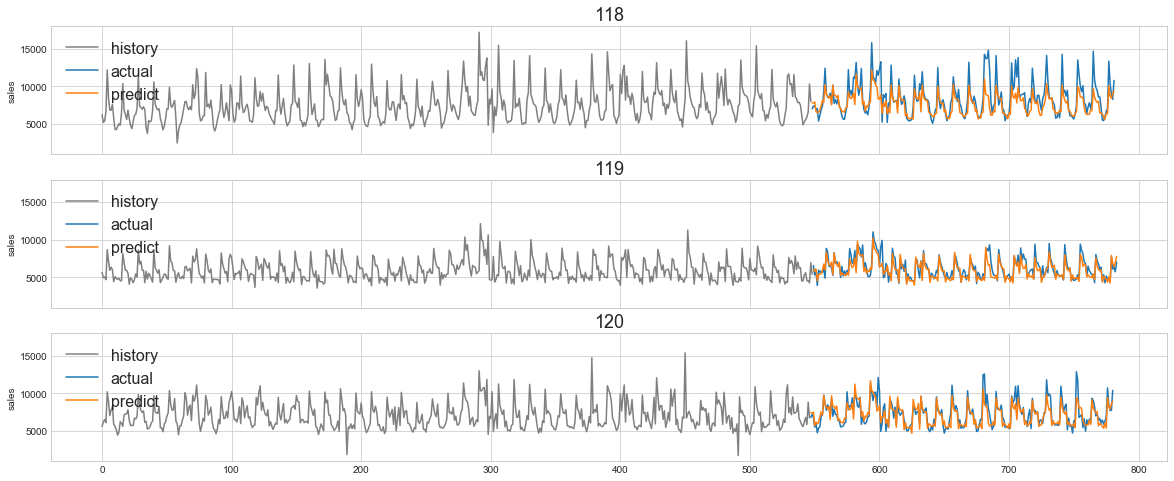

In [39]:
n_rows, n_cols = 3, 1
f, ax = plt.subplots(n_rows, n_cols, figsize=(20, 8), sharex=True, sharey=True)

for r, idx in enumerate(np.arange(pos, pos + n_rows)):
    samples = merge.query(f'store == {idx}').sort_values('date')
    hist = samples[samples.predict.isnull()]
    predict = samples[samples.predict.notnull()]
    ax[r].plot(np.arange(len(hist)), hist.sales.values, c='gray', label='history')
    ax[r].plot(np.arange(len(hist), len(hist) + len(predict)), predict.sales.values, label='actual')
    ax[r].plot(np.arange(len(hist), len(hist) + len(predict)), predict.predict.values, label='predict')
    ax[r].set_title(f'{idx}', size=18)
    ax[r].set_ylabel('sales')
    ax[r].set_ylabel('sales')
    ax[r].grid(True)
    ax[r].legend(loc='best', prop={'size': 16})
pos += n_rows
plt.show()

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
## Appendix

+ Use `tf.saved_model.loader.load`, only for `json_serving_input_fn `

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
test_df = ctrl.transform(pd.Series({'fpath': './data/test.csv'}))
params = pd.Series({
    'datasource': test_df,
    'is_src_file': False
})
pred = ctrl.local_predict_alt(params)
print(pred)

## Tensor data inspection

In [7]:
from trainer import app_conf, metadata, input, service, model
from trainer.ctrl import Ctrl
"""
'sales_mean', 'promo2since', 'competition_distance', 'competition_open_since', 
'state_embedding', 'state_holiday_embedding', 'assortment_embedding', 
'store_type_embedding', 'competition_open_since_month_embedding', 
'competition_open_since_year_embedding', 'promo2since_week_embedding', 
'promo2since_year_embedding', 'year_embedding', 'month_embedding', 
'day_embedding', 'store_embedding', 'day_of_week_indicator', 
'open_indicator', 'promo_indicator', 'promo2_indicator', 'school_holiday_indicator'

'store', 'day_X_day_of_week_X_month_X_promo_X_promo2_X_year', 
'promo_X_promo2_X_school_holiday_X_state_holiday', 'assortment_X_day_of_week_X_state_X_store_type', 
'competition_open_since_month_X_competition_open_since_year'
"""
origin, encoded, all_ = Ctrl.instance.inspect('month', 'month_embedding', typ='deep')
print(all_.shape)
print(origin)
print(encoded)

2018-08-13 17:21:37,283 - trainer.input - INFO [line:456] - 
2018-08-13 17:21:37,285 - trainer.input - INFO [line:457] - * data input_fn:
2018-08-13 17:21:37,286 - trainer.input - INFO [line:458] - ================
2018-08-13 17:21:37,287 - trainer.input - INFO [line:459] - Mode: train
2018-08-13 17:21:37,288 - trainer.input - INFO [line:460] - Input file(s): D:\Python\notebook\ml_specialized\rossmann/data/processed/transformed/tr.csv
2018-08-13 17:21:37,289 - trainer.input - INFO [line:461] - Files encoding: csv
2018-08-13 17:21:37,290 - trainer.input - INFO [line:462] - Batch size: 5000
2018-08-13 17:21:37,291 - trainer.input - INFO [line:463] - Epoch count: 1
2018-08-13 17:21:37,292 - trainer.input - INFO [line:464] - Thread count: 8
2018-08-13 17:21:37,293 - trainer.input - INFO [line:465] - Shuffle: False
2018-08-13 17:21:37,294 - trainer.input - INFO [line:466] - ================
2018-08-13 17:21:37,295 - trainer.input - INFO [line:467] - 
2018-08-13 17:21:37,308 - trainer.input 

## Test

In [73]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
print( ctrl.test() )

2018-07-31 10:51:58,870 - trainer.input - INFO [line:412] - 
2018-07-31 10:51:58,871 - trainer.input - INFO [line:413] - * data input_fn:
2018-07-31 10:51:58,873 - trainer.input - INFO [line:414] - ================
2018-07-31 10:51:58,874 - trainer.input - INFO [line:415] - Mode: train
2018-07-31 10:51:58,875 - trainer.input - INFO [line:416] - Input file(s): D:\Python\notebook\ml_specialized\rossmann/data/processed/transformed/tr.csv
2018-07-31 10:51:58,876 - trainer.input - INFO [line:417] - Files encoding: csv
2018-07-31 10:51:58,877 - trainer.input - INFO [line:418] - Batch size: 5000
2018-07-31 10:51:58,878 - trainer.input - INFO [line:419] - Epoch count: 10
2018-07-31 10:51:58,879 - trainer.input - INFO [line:420] - Thread count: 8
2018-07-31 10:51:58,880 - trainer.input - INFO [line:421] - Shuffle: False
2018-07-31 10:51:58,880 - trainer.input - INFO [line:422] - ================
2018-07-31 10:51:58,881 - trainer.input - INFO [line:423] - 
2018-07-31 10:51:58,893 - trainer.input